## Análise e Previsão Univariada de Séries Temporais: Chamadas de Atendimento ao Cidadão (CSR)

##### Descrição dos dados:

- Acesso: https://data.cincinnati-oh.gov/Efficient-Service-Delivery/Citizen-Service-Request-CSR-Call-Center-Calls/k2qr-ck2v/about_data
- Sobre: Este conjunto de dados contém o registro de todas as chamadas de Solicitação de Atendimento ao Cidadão (CSR) recebidas na central de atendimento da Secretaria de Serviços Públicos (DPS) na cidade de Cincinnati em Ohio, EUA. As Solicitações de Serviço do Cidadão (CSR) oferecem aos residentes de Cincinnati a oportunidade de enviar solicitações de serviço para questões como coleta de móveis, grama alta e reparos de buracos.

##### Entregáveis:

1. Carregamento, Preparação e Limpeza de Dados
    - Visualização inicial
    - Sumarizar dados de quantidade de ligações (inicialmente em meses, Ex: jun/21 30)
    - Verificar dados faltantes

2. Análise Descritiva
    - Decribe dos dados para analisar principais estatísticas
    - Drigrama de Caixa (Entender presença de outliers e tratar)

    Entendendo Distribuição
    - Plot dos dados em um histograma (Entender distribuição dos dados)
    - Q-Q Plot
    
    Entendendo a Série - Verificando Estacionariade
    - Plot gráfico série temporal para avaliar visualmente se há tendência, sazonalidade...
    - Plot gráfico com decomposição série temporal
    - Aplicar log e/ou diferenciação dos dados para estabilizar a série (diferenciação sazonal caso haja, tentar possibilidades)
    - Plot da série após isso, verificar visualmente se há estacionariadade 
    - Describe dos dados para avaliar se a média tende a 0
    - Plot Q-Q Plot

    Gráficos de Autocorrelação
    - Plot Autocorrelação (Verificar tabela com comportamentos)
    - Plot Autocorrelação Parcial (Verificar tabela com comportamentos)
    - Inspeção Visual sobre quais candidados para modelagem ARIMA
    
3. Previsão com ARIMA
    - Divisão dados em Treino, Teste

    Treino
    - Aplicação ARIMA (aplicar nos dados não diferenciados)
        - Avaliar valores de AIC (menor melhor)
        - Análises de resíduos (plot resíduos ARIMA, Q-Q Plot, ACF (valores dentro da faixa de 95%), ACFP (valores dentro da faixa de 95%))
    - Plot da série com ajuste
    
    Teste
    - Predict da base utilizando o Teste
    - Plot Serie com a previsão
    - Calcular MAPE e RMSE (verificar para voltar medida da série)

4. Previsão com Aprendizagem de Máquina (Random Florest)

    - Divisão dados em Treino, Teste
    - Previsões
    - Aplicação em Teste
    - Plot Séries com Previsões
    - Calcular MAPE e RMSE

5. Conclusão

##### Importação Bibliotecas

In [315]:
# Importação, manipulação e análises gráficas com dados
import os
from google.cloud import bigquery
import pandas as pd
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Previsões com modelagem ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose # Trabalhar com decomposição componentes Séries Temporais
from statsmodels.graphics.tsaplots import plot_acf # Plot da função de autocorrelação
from statsmodels.graphics.tsaplots import plot_pacf # Plot da função de autocorrelação parcial
import statsmodels.api as sm # Plot do gráfico Q-QPlot
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats # Plot do gráfico Q-QPlot (Ajuda para verificar se os dados aproximam de uma distribuição normal visualmente)
from statsmodels.tsa.stattools import adfuller

# Previsões com Random Forest e cálculo métricas
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split

##### 1. Carregamento, Preparação e Limpeza de Dados

Informações sobre conjunto de dados bruto

In [273]:
# Definir variável de ambiente
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "../../data/credentials_bigquery.json" 

# Criar cliente de conexão com banco de dados BigQuery
client = bigquery.Client()

In [4]:
# Carregamento da query da BigQuery tabela completa
query_job = client.query("""
SELECT
     *
FROM `project-tcc-434118.SILVER_ATD_CSR.tb_interacao_receptivo`       
""")

# Convertendo objeto de consulta BigQuery em um dataframe pandas
df = query_job.to_dataframe()

/home/aasantos/anaconda3/envs/tcc/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [5]:
df.head(5)

,registroId,agenteDispId,dtChamada,acaoChamadaId,acaoMotivoChamadaId,chamadaId,dtEncerramentoConnHora,dtEntradaFilaHora,numSequencial,servicoId,...,dtInicioPreVisualizacao,dtFimPreVisualizacao,dtResposta,tempoRespostaSeg,tempoConversaSeg,tempoEncerramentoSeg,nivelServico,statusAbandono,statusChamada,dtProcessamento
0,93093223,-1,2014-09-12,3,2,3,2014-09-12 05:04:41,NaT,9309322,106,...,NaT,NaT,NaT,0,238,0,0,0,1,2024-09-10
1,11733172492,-1,2015-06-23,3,2,492,2015-06-23 05:57:55,NaT,11733172,106,...,NaT,NaT,NaT,0,82,0,0,0,1,2024-09-10
2,930934214,-1,2014-09-12,3,2,14,2014-09-12 05:03:56,NaT,9309342,106,...,NaT,NaT,NaT,0,43,0,0,0,1,2024-09-10
3,93083687,-1,2014-09-12,3,2,7,2014-09-12 04:58:43,NaT,9308368,106,...,NaT,NaT,NaT,0,125,0,0,0,1,2024-09-10
4,289477294486,<NA>,2019-11-15,21,4,4486,NaT,2019-11-14 20:25:34,28947729,106,...,NaT,NaT,NaT,23,0,0,1,0,0,2024-09-10


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841391 entries, 0 to 841390
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   registroId               841391 non-null  Int64         
 1   agenteDispId             634043 non-null  Int64         
 2   dtChamada                841391 non-null  dbdate        
 3   acaoChamadaId            841391 non-null  Int64         
 4   acaoMotivoChamadaId      841391 non-null  Int64         
 5   chamadaId                841391 non-null  Int64         
 6   dtEncerramentoConnHora   634054 non-null  datetime64[us]
 7   dtEntradaFilaHora        840325 non-null  datetime64[us]
 8   numSequencial            841391 non-null  Int64         
 9   servicoId                841391 non-null  Int64         
 10  estacao                  634020 non-null  Int64         
 11  grupoTrabalhoId          841391 non-null  Int64         
 12  dtTerminoEncerra

In [32]:
df.shape

(841391, 23)

In [ ]:
# Quantidade de registros por ano

df['dtChamada'] = pd.to_datetime(df['dtChamada'])
contagem_por_ano = df.groupby(df['dtChamada'].dt.year).size()
print(contagem_por_ano)


dtChamada
2014     32595
2015    110687
2016    108417
2017    101183
2018    104301
2019    105273
2020     96453
2021    101117
2022     81070
2023       295
dtype: int64


Base Segmentada: Quantidade de Chamadas por meses

In [358]:
query_job = client.query("""
SELECT
     CAST(CONCAT(EXTRACT(YEAR FROM dtChamada), '-', EXTRACT(MONTH FROM dtChamada), '-1') AS DATE) AS mesAno
    ,COUNT(1) AS qtdChamada

FROM `project-tcc-434118.SILVER_ATD_CSR.tb_interacao_receptivo`


GROUP BY
    CAST(CONCAT(EXTRACT(YEAR FROM dtChamada), '-', EXTRACT(MONTH FROM dtChamada), '-1') AS DATE)        
""")

df_meses = query_job.to_dataframe()

df_meses['mesAno'] = pd.to_datetime(df_meses['mesAno'], format="%m-%d-%Y")
df_meses.sort_values(by=['mesAno'], ascending=True, inplace=True)
df_meses.reset_index(inplace=True)

df_meses = df_meses[['mesAno', 'qtdChamada']]
df_meses

,mesAno,qtdChamada
0,2014-04-01,44
1,2014-05-01,13
2,2014-06-01,9
3,2014-07-01,480
4,2014-08-01,8345
...,...,...
110,2023-06-01,19
111,2023-07-01,28
112,2023-08-01,27
113,2023-09-01,25


In [359]:
# Verificando se há meses sem volumetria

dt_min        = df_meses['mesAno'].min()
dt_max        = df_meses['mesAno'].max()
qtd_mes_prev  = np.round(((dt_max - dt_min).days + 30)*12/(365), 0)
qtd_mes_base  = len(df_meses)

print(f'''Data Mínima: {dt_min}
Data Máxima: {dt_max}
Quantidade Meses Previsto Intervalo: {qtd_mes_prev} 
Quantidade Meses na Base: {qtd_mes_base}
''')

if qtd_mes_base == qtd_mes_prev:
    print("Base de dados sem meses faltantes")
else:
    print(f"Base com meses faltantes, com diferença entre previsto e real de {qtd_mes_prev - qtd_mes_base}")

Data Mínima: 2014-04-01 00:00:00
Data Máxima: 2023-10-01 00:00:00
Quantidade Meses Previsto Intervalo: 115.0 
Quantidade Meses na Base: 115

Base de dados sem meses faltantes


In [360]:
df_meses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   mesAno      115 non-null    datetime64[ns]
 1   qtdChamada  115 non-null    Int64         
dtypes: Int64(1), datetime64[ns](1)
memory usage: 2.0 KB


##### 2. Análise Descritiva

Algumas métricas estatísticas dos dados

In [361]:
df_meses.describe()

,mesAno,qtdChamada
count,115,115.0
mean,2018-12-31 08:58:26.086956544,7316.443478
min,2014-04-01 00:00:00,9.0
25%,2016-08-16 12:00:00,6234.5
50%,2019-01-01 00:00:00,8085.0
75%,2021-05-16 12:00:00,9416.5
max,2023-10-01 00:00:00,14758.0
std,NaN,3519.78547


Verificando volumetria ao longo do tempo

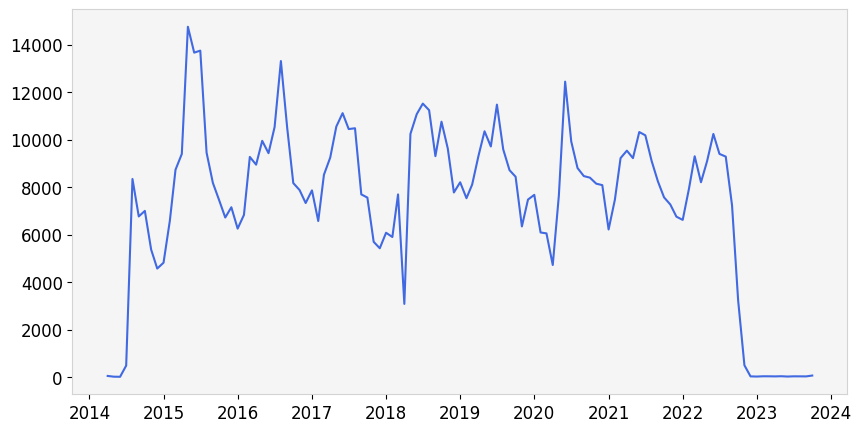

In [381]:
def graf_line(x, y, title=""):
    
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(
        x, 
        y, 
        linewidth=1.5,
        color='#4169E1'
    )
    ax.set_title(title, fontsize=15)
    #ax.set_xlabel('Data', fontsize=14)
    #ax.grid(True, linestyle='--', alpha=1, color='gray')
    ax.set_facecolor(color='whitesmoke')
    ax.tick_params(axis='both', which='major', labelsize=12)

    #borda
    ax.spines['top'].set_color('lightgray')       # Borda superior
    ax.spines['right'].set_color('lightgray')     # Borda direita
    ax.spines['bottom'].set_color('lightgray')    # Borda inferior
    ax.spines['left'].set_color('lightgray')      # Borda esquerda

graf_line(df_meses['mesAno'], df_meses['qtdChamada'])

##### Investigando Outliers
- A partir de valores de média, mínimo e máximo, provavelmente há meses com volumetrias atípicas

BoxPlot

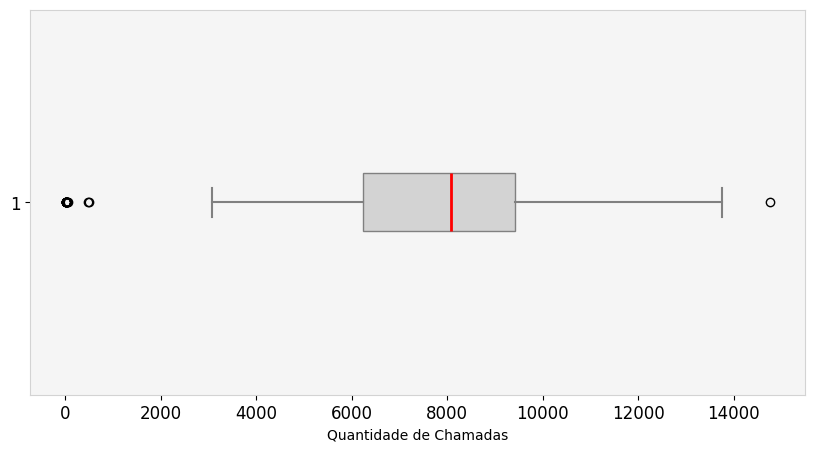

In [362]:
def graf_box_plot(data, title=""):
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.boxplot(data, vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightGrey', color='gray'),
            whiskerprops=dict(color='grey', linewidth=1.5),
            capprops=dict(color='grey', linewidth=1.5),
            medianprops=dict(color='red', linewidth=2))

    # Personalização o gráfico
    ax.set_title(title)
    ax.set_xlabel("Quantidade de Chamadas")
    ax.set_facecolor(color='whitesmoke')
    ax.tick_params(axis='both', which='major', labelsize=12)

    #borda
    ax.spines['top'].set_color('lightgray')       # Borda superior
    ax.spines['right'].set_color('lightgray')     # Borda direita
    ax.spines['bottom'].set_color('lightgray')    # Borda inferior
    ax.spines['left'].set_color('lightgray')      # Borda esquerda


    # Exibindo o gráfico
    plt.show()

graf_box_plot(df_meses['qtdChamada'])

Histograma

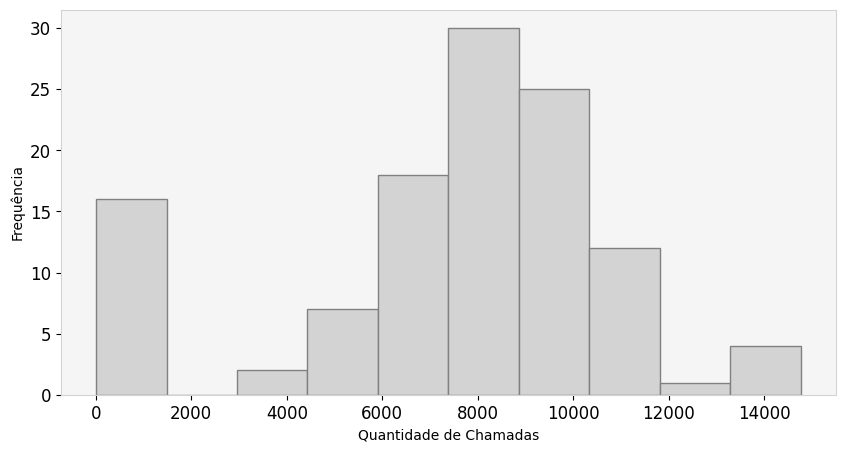

In [363]:
def graf_histograma(data, title=""):
    fig, ax = plt.subplots(figsize=(10, 5))

    # Criando o histograma
    ax.hist(data, color='lightgrey', edgecolor='grey')

    # Personalizando o gráfico
    ax.set_xlabel("Quantidade de Chamadas")
    ax.set_ylabel("Frequência")
    ax.set_title(title)
    ax.set_facecolor('whitesmoke')
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Ajustando as bordas do gráfico
    ax.spines['top'].set_color('lightgray')       # Borda superior
    ax.spines['right'].set_color('lightgray')     # Borda direita
    ax.spines['bottom'].set_color('lightgray')    # Borda inferior
    ax.spines['left'].set_color('lightgray')      # Borda esquerda

    # Exibindo o gráfico
    plt.show()

graf_histograma(df_meses['qtdChamada'])

A partir dos gráficos de caixa e histogramas e métricas estatísticas mostradas, é possível observar alguns outliers, visto que há valores de mínimo e máximo bem distantes da média e fora do Intervalo IQR (diferença entre quartis: Q3 - Q1) conforme visualização do gráfico box plot. Observa no gráfico histograma que a ditribuição dos dados apróxima-se a uma distribuição normal, isso é bom indicativo para ajustamento dos dados no futuro. Abaixo iremos verificar os meses que aparentam ser outliers e adotar ponderações para continuar as análises.

![alt text](image.png)

Fonte: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

In [364]:
# Calculando estatísticas

q1      = df_meses['qtdChamada'].quantile(0.25)
q3      = df_meses['qtdChamada'].quantile(0.75)
mediana  = df_meses['qtdChamada'].median()

iqr_score = q3 - q1
inferior = q1 - (1.5*iqr_score)
superior = q3 + (1.5*iqr_score)

print(f'Mediana: {mediana}\nQ1: {q1}\nQ3: {q3}\nO IQR Score calculado é: {iqr_score}\nLimite inferior = {inferior}\nLimite Superior = {superior}')

# Mostrando linhas consideradas outiliers, que estão fora IQR

df_out = df_meses[(df_meses['qtdChamada'] <= inferior) | (df_meses['qtdChamada'] >= superior)]

display(df_out)

Mediana: 8085.0
Q1: 6234.5
Q3: 9416.5
O IQR Score calculado é: 3182.0
Limite inferior = 1461.5
Limite Superior = 14189.5


,mesAno,qtdChamada
0,2014-04-01,44
1,2014-05-01,13
2,2014-06-01,9
3,2014-07-01,480
13,2015-05-01,14758
103,2022-11-01,493
104,2022-12-01,26
105,2023-01-01,19
106,2023-02-01,30
107,2023-03-01,29


Visualização BoxPlot com limites inferiores e superiores

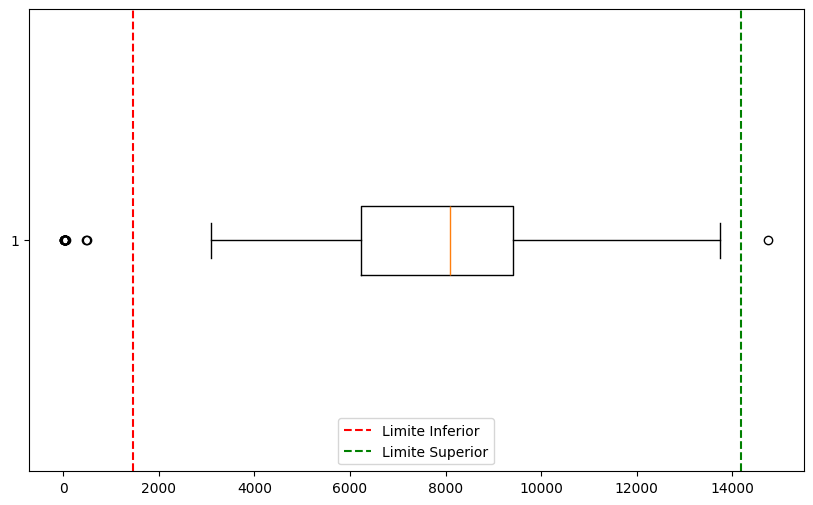

In [365]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.boxplot(df_meses['qtdChamada'], vert=False)
ax.axvline(inferior, color='red', linestyle='--', label='Limite Inferior')
ax.axvline(superior, color='green', linestyle='--', label='Limite Superior')
ax.legend()
plt.show()

Observando os valores considerados outliers, é possível observar que a maioria trata-se de valores iniciais ou finais do conjunto de dados, com exceção do registro 13, do mês de maio de 2015. Para previsões, optaremos por excluir os dados considerados outliers, mantendo apenas o registro 13. Esses valores podem ser devido a algum problema de ingestão, visto que estão muito afastados da mediana histórica, e estes, não vão atrapalhar para a futura previsão. No entanto, para o registro 13 iremos plotar uma visualização de 2015 para entender melhor o cenário de volume neste ano.

Através dos gráficos, é possível verificar pontos extremos mínimos no ínicio da série e no final conforme a tabela anterior visualizada contendo os outliers. Porém para o ano de 2015, observa-se que foi uma ano com maior volumetria comparados com os demais, acredita-se ser algo que pode acontecer a depender de variáveis externas, como eventos, economia e entre outros fatores. Por isso, optaremos em exlcuir apenas os extremos mínimos e máximos, seguindo as análises com o período de 08/2014 a 08/2022, será desconsiderado os dois últimos meses de 2022 para que tenhamos um intevalo 8 anos completo

Excluíndo Outliers

,mesAno,qtdChamada
4,2014-08-01,8345
5,2014-09-01,6766
6,2014-10-01,7000
7,2014-11-01,5368
8,2014-12-01,4570
...,...,...
96,2022-04-01,8207
97,2022-05-01,9093
98,2022-06-01,10242
99,2022-07-01,9401


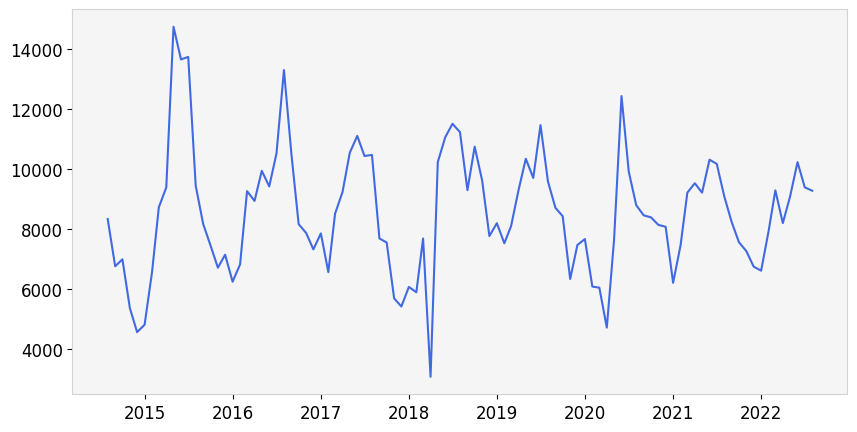

In [367]:
df_meses_v1 = df_meses[~(df_meses['qtdChamada'] <= inferior)]
df_meses_v1 = df_meses_v1[(df_meses_v1['mesAno'] <= '2022-08-01')]

display(df_meses_v1)
graf_line(df_meses_v1['mesAno'], df_meses_v1['qtdChamada'])


Entendo a distribuição dos dados

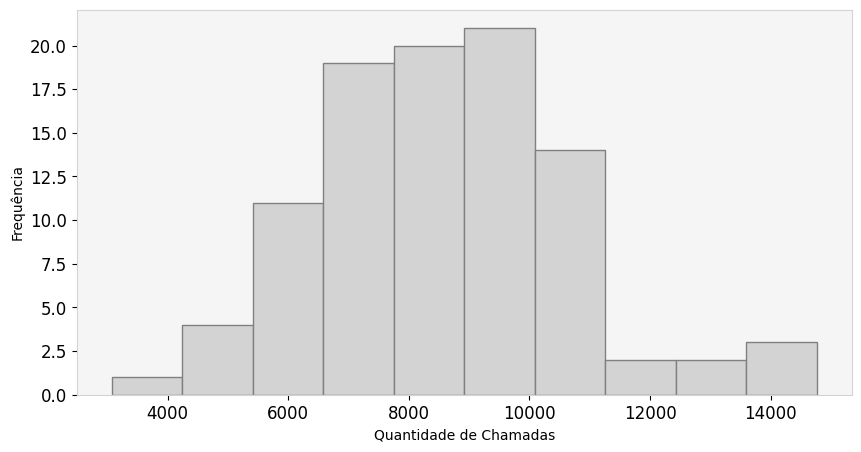

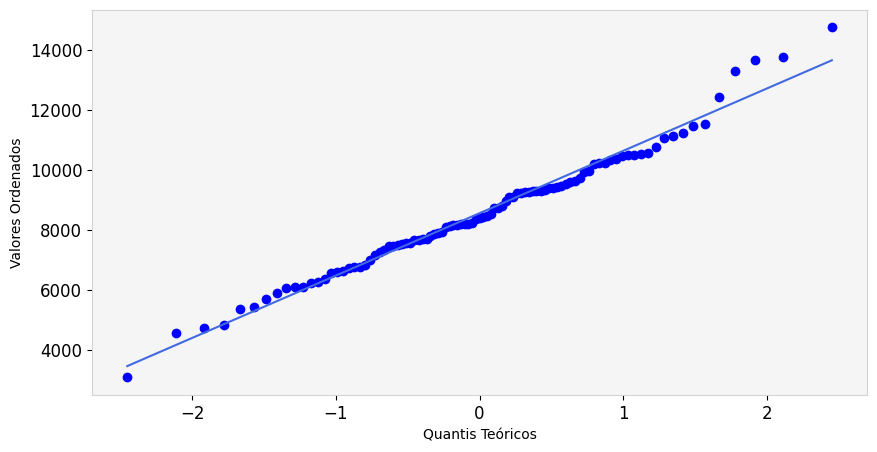

In [368]:
def graf_qq(data, title=""):
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Cria o Q-Q plot
    stats.probplot(data, dist="norm", plot=ax)
    
    # Personalizações do gráfico
    ax.get_lines()[1].set_color('#4169E1')  # Linha de ajuste
    ax.get_lines()[1].set_linewidth(1.5)
    
    ax.set_title(title, fontsize=15)
    ax.set_facecolor(color='whitesmoke')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('Quantis Teóricos')
    ax.set_ylabel('Valores Ordenados')

    # Personaliza bordas
    ax.spines['top'].set_color('lightgray')
    ax.spines['right'].set_color('lightgray')
    ax.spines['bottom'].set_color('lightgray')
    ax.spines['left'].set_color('lightgray')
    
    plt.show()

graf_histograma(df_meses_v1['qtdChamada'])
graf_qq(df_meses_v1['qtdChamada'])

Teste de Dickey-Fuller

In [369]:
resultado_adf = adfuller(df_meses_v1['qtdChamada'])
print(f"Estatística de Teste ADF: {resultado_adf[0]}")
print(f"Valor-p: {resultado_adf[1]}")
if resultado_adf[1] <= 0.05:
    print("A série é estacionária.")
else:
    print("A série não é estacionária.")

Estatística de Teste ADF: -7.607593437764474
Valor-p: 2.3001790872036207e-11
A série é estacionária.


A partir dos dois gráficos, histograma e Q-Q Plot podemos considerar que a distribuição dos dados seguem a uma aproximação normal, como isso não há necessidade de transformação dos dados através um Log ou diferenciação, pois com essa caractéristicas podemos considerar o conjunto estacionário. Para fins de validação, ao aplicar o teste de Dickey-Fuller obtem-se o resultado de estacionáriedade.

Decomposição da série

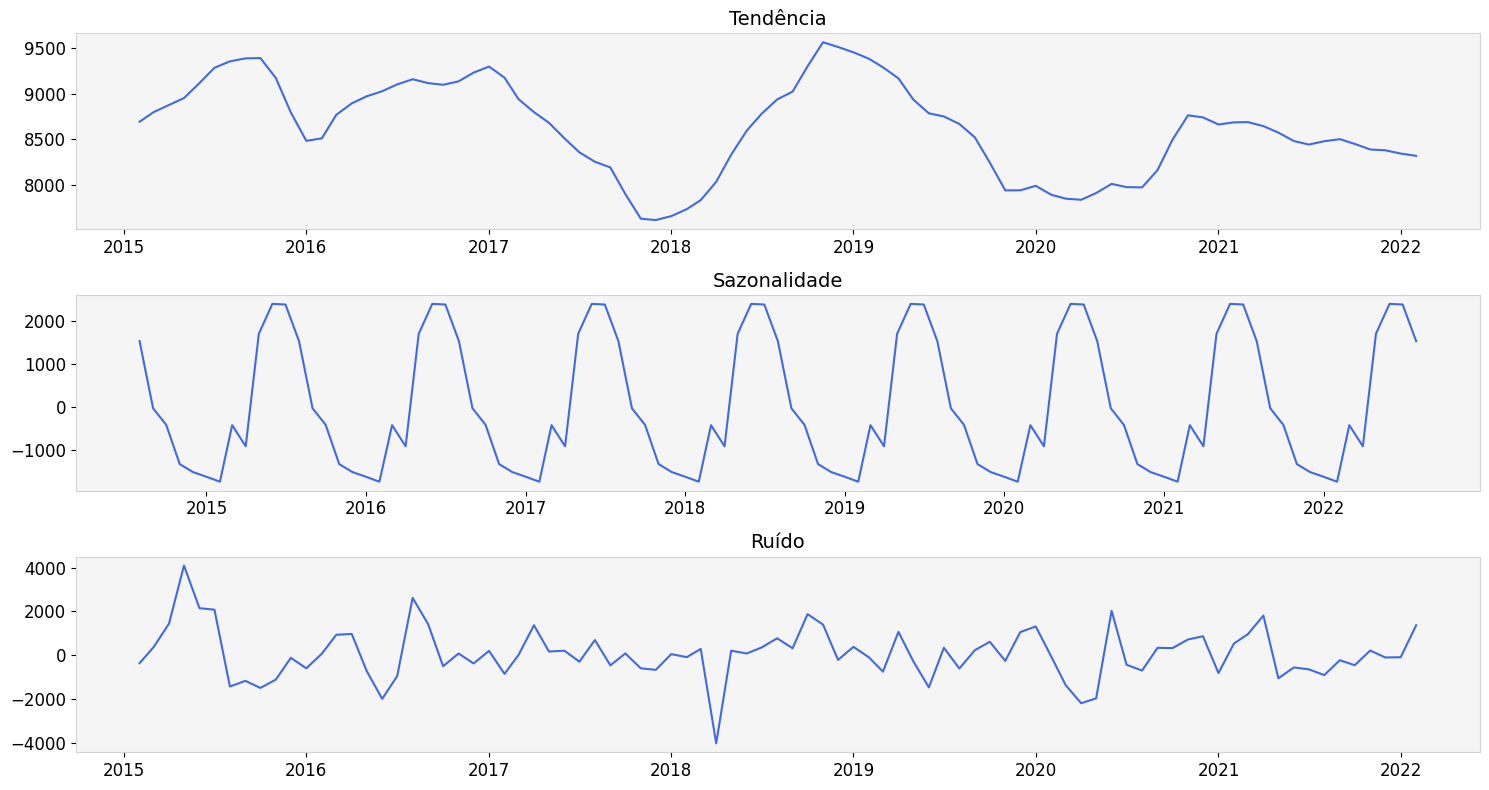

In [370]:
def plot_ax(eixo_x, y, ax, title="", color_line="", label_legend=""):
    
    if color_line == "": color_line='#4169E1'

    ax.plot(
        eixo_x, 
        y, 
        linewidth=1.5,
        color=color_line,
        label=label_legend
    )
    ax.set_title(title, fontsize=14)
    #ax.set_xlabel('Data', fontsize=14)
    #ax.grid(True, linestyle='--', alpha=1, color='gray')
    ax.set_facecolor(color='whitesmoke')
    ax.tick_params(axis='both', which='major', labelsize=12)

    #borda
    ax.spines['top'].set_color('lightgray')       # Borda superior
    ax.spines['right'].set_color('lightgray')     # Borda direita
    ax.spines['bottom'].set_color('lightgray')    # Borda inferior
    ax.spines['left'].set_color('lightgray')      # Borda esquerda

def graf_decomp(eixo_x, data):    
    
    result = seasonal_decompose(data, model='additive', period=12)

    # Plotar em tamanho maior
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8))

    plot_ax(eixo_x, result.trend, ax1, "Tendência")
    plot_ax(eixo_x, result.seasonal, ax2, "Sazonalidade")
    plot_ax(eixo_x, result.resid, ax3, "Ruído")

    plt.tight_layout()
    plt.show()

graf_decomp(df_meses_v1['mesAno'], df_meses_v1['qtdChamada'])

Gráficos de Autocorrelação

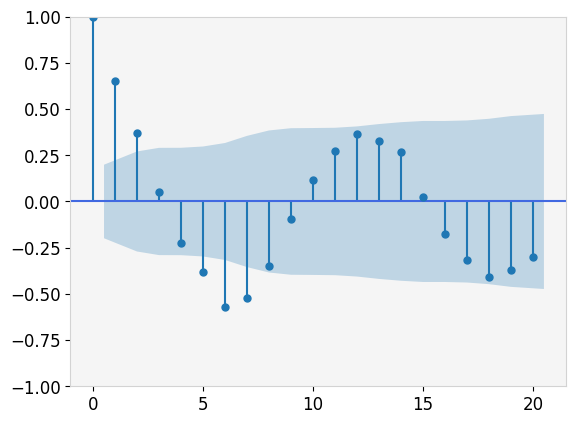

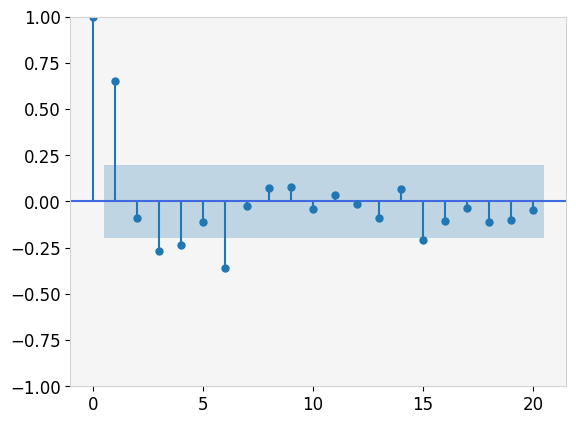

In [371]:
def graf_autocorr(plot, data, title=""):

    # Plot com estilo customizado
    fig = plot(data.dropna(), lags=20, alpha=0.05)
    ax = fig.gca()  # Obtém o eixo atual

    # Customiza o estilo do gráfico
    ax.set_facecolor('whitesmoke')
    ax.tick_params(axis='both', which='major', labelsize=12)
    #ax.grid(True, linestyle='--', color='gray', alpha=0.7)

    # Título e cor da linha principal
    ax.lines[0].set_linewidth(1.5)
    ax.lines[0].set_color('#4169E1')
    ax.set_title(title, fontsize=15)

    # Configuração das bordas
    for spine in ax.spines.values():
        spine.set_color('lightgray')

    # Exibe o gráfico
    plt.show()

graf_autocorr(plot_acf, df_meses_v1['qtdChamada'])
graf_autocorr(plot_pacf, df_meses_v1['qtdChamada'])


A partir dos Gráficos de autocorrelação podemos verificar possíveis candidatos a ordens para parte Autoregressiva e Média Móvel do modelo.

AR(p) -> A partir do gráfico de FACP (Autocorrelação Parcial), os pontos fora do intervalo de confiança de 95%, são {1, 3, 4, 6} (2 com extremos de valor: 1 e 6)

MA(q) -> A partir do gráfico de FAC (Autocorrelação), os pontos fora do intervalo de confiança de 95%, são {1, 2, 5, 6, 7} (2 com extremos de valor: 1 e 6)

Para parâmetro i da modelagem AR(I)MA testaremos com 0 (nenhuma diferenciação) e 1 (verificar se há uma influência do valor antecessor no posterior a ele).

#### 3. Previsão com ARIMA

Divisão dados em Treino e Teste

In [372]:
# Ordenar o DataFrame por data (caso ainda não esteja)
df_meses_v1 = df_meses_v1.sort_index()

# Extrair a coluna de interesse, assumindo que já é uma série temporal com índice datetime
data = df_meses_v1['qtdChamada']
eixo = df_meses_v1['mesAno']

# Divisão Treino e Teste
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Coletando Eixo
eixo_train, eixo_test = eixo[:train_size], eixo[train_size:]

Criação função para Previsão ARIMA e, avaliar valores de AIC, MAPE e RMSE para escolha do melhor ajuste

In [373]:
# Função para aplicar modelagem ARIMA
def fore_arima(p, i, q):
    
    # Aplicar ajuste na base de treinamento
    model = ARIMA(train, order=(p, i, q))
    
    # Realizando simulaçao previsão na base treino para cálculo AIC
    fitted_model = model.fit()

    # Avaliação do AIC
    print(f"AIC do Modelo ARIMA: {fitted_model.aic}")

    # Coletar dados residuais do ajuste
    residuals = fitted_model.resid

    # Plot dos Resíduos
    #lag = [i for i in residuals.index]
    graf_line(eixo_train, residuals, "")
    # Q-Q Plot dos Resíduos
    graf_qq(residuals, "")

    # FAC e FACP dos Resíduos
    graf_autocorr(plot_acf, residuals, "")
    graf_autocorr(plot_pacf, residuals, "")

    # Plot da Série com Ajuste
    
    fig, ax = plt.subplots(figsize=(10, 5))
    plot_ax(eixo_train, train, ax, "", "", "Treino")
    plot_ax(eixo_train, fitted_model.fittedvalues, ax, "", "#ff7f0e", "Ajuste ARIMA")
    ax.legend()
    plt.show()

    # Previsão com o Conjunto de Teste
    forecast = fitted_model.get_forecast(steps=len(test))
    forecast_values = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int(alpha=0.05)

    # Plot da Série com Previsão
    fig, ax = plt.subplots(figsize=(10, 5))

    plot_ax(eixo_train, train, ax, "", "", "Treino")
    plot_ax(eixo_test, test, ax, "", "#ff7f0e", "Teste")
    plot_ax(eixo_test, forecast_values, ax, "", '#2ca02c', 'Previsão ARIMA')
    ax.fill_between(eixo_test,
                    forecast_conf_int.iloc[:, 0],
                    forecast_conf_int.iloc[:, 1], color='#2ca02c', alpha=0.2, label="Intervalo de Confiança 95%")
    ax.legend()
    plt.show()


    # Avaliação das Métricas de Previsão
    mape = mean_absolute_percentage_error(test, forecast_values)
    rmse = np.sqrt(mean_squared_error(test, forecast_values))

    print(f"MAPE: {mape:.2%}")
    print(f"RMSE: {rmse:.2f}")

# Avaliação dos modelos ARIMA para candidatos escolhidos anteriormente
def avaliacao_modelo(p, i, q):
    
    # Aplicar ajuste na base de treinamento
    model = ARIMA(train, order=(p, i, q))
    
    # Realizando simulaçao previsão na base treino para cálculo AIC
    fitted_model = model.fit()

    # Previsão com o Conjunto de Teste
    forecast = fitted_model.get_forecast(steps=len(test))
    forecast_values = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int(alpha=0.05)

    # Avaliação das Métricas de Previsão
    mape = mean_absolute_percentage_error(test, forecast_values)
    rmse = np.sqrt(mean_squared_error(test, forecast_values))

    return (fitted_model.aic, mape, rmse)

Criação de um dataframe para comparação das variações de ajuste da modelagem ARIMA

In [374]:
list_p = [1, 3, 4, 6]
list_q = [1, 2, 5, 6, 7]
list_i = [0, 1]

metrics_data = []

j = 0

for i in list_i:
    for p in list_p:
        for q in list_q:
            aic, mape, rmse = avaliacao_modelo(p, i, q)
            # Adiciona os dados a um dicionário e depois à lista
            metrics_data.append({
                "modelo": f"ARIMA({p},{i},{q})",
                "AIC": aic,
                "MAPE": mape,
                "RMSE": rmse
            })

# Cria o DataFrame a partir da lista de dicionários
df_metrics = pd.DataFrame(metrics_data)


In [375]:
df_metrics.sort_values(by=["MAPE"], ascending=True, inplace=True)

df_metrics

,modelo,AIC,MAPE,RMSE
38,"ARIMA(6,1,6)",1354.306816,0.094499,973.506052
39,"ARIMA(6,1,7)",1358.852049,0.097607,1001.696347
33,"ARIMA(4,1,6)",1351.129691,0.098121,1012.005960
37,"ARIMA(6,1,5)",1353.613415,0.100059,1035.544516
16,"ARIMA(6,0,2)",1358.839831,0.103835,972.595881
15,"ARIMA(6,0,1)",1356.874013,0.107466,1001.017072
5,"ARIMA(3,0,1)",1358.036227,0.112691,1088.528353
12,"ARIMA(4,0,5)",1350.475011,0.114305,1169.430346
26,"ARIMA(3,1,2)",1355.890804,0.115292,1105.757985
32,"ARIMA(4,1,5)",1356.060263,0.118289,1112.852534


AIC do Modelo ARIMA: 1354.3068159725194


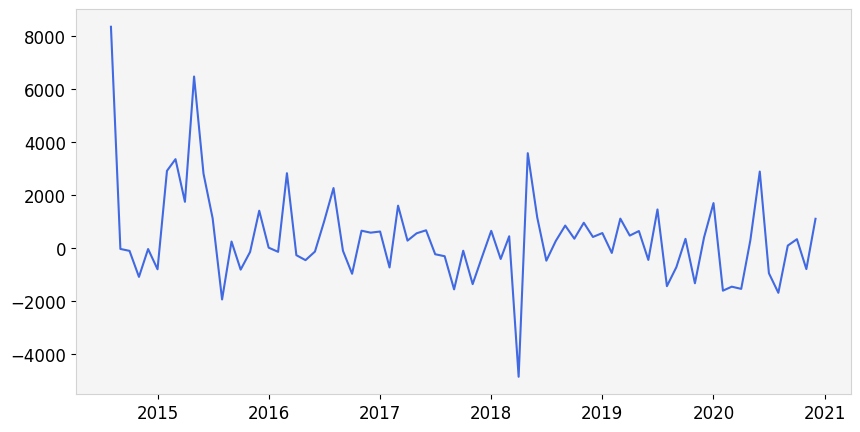

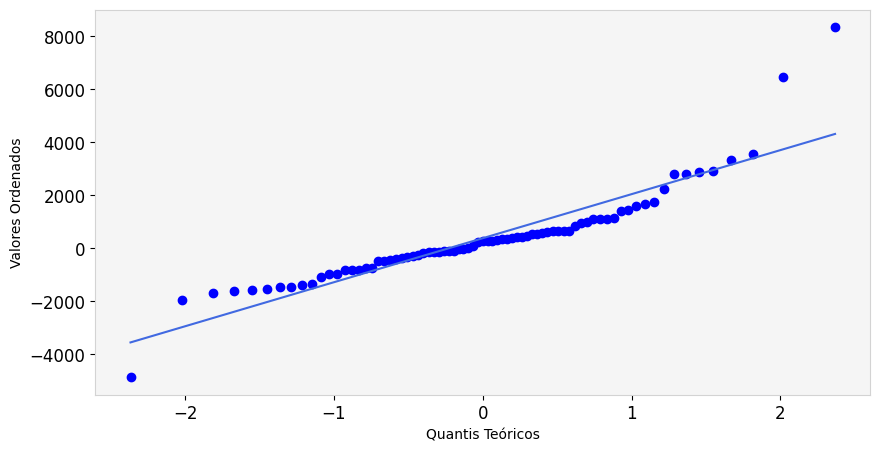

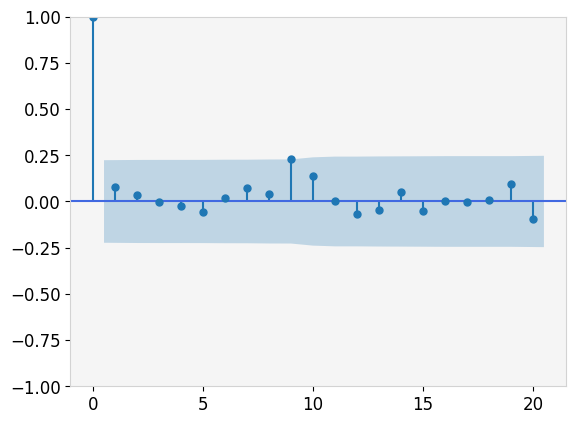

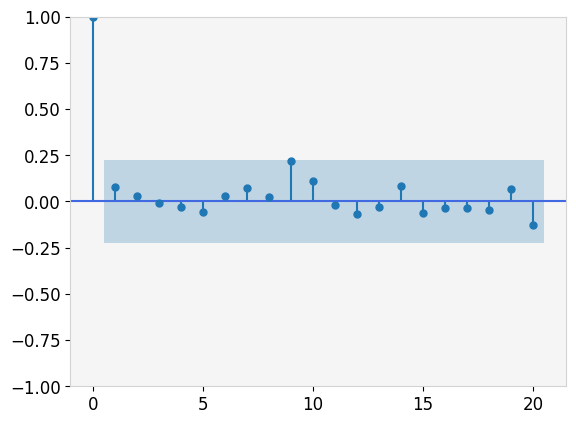

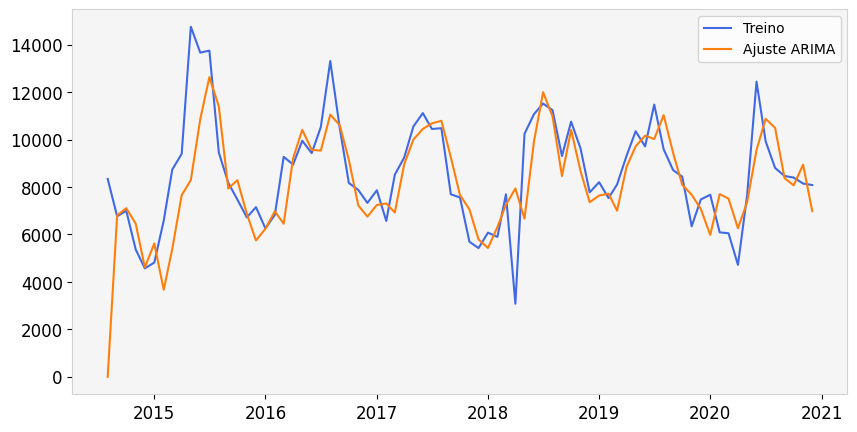

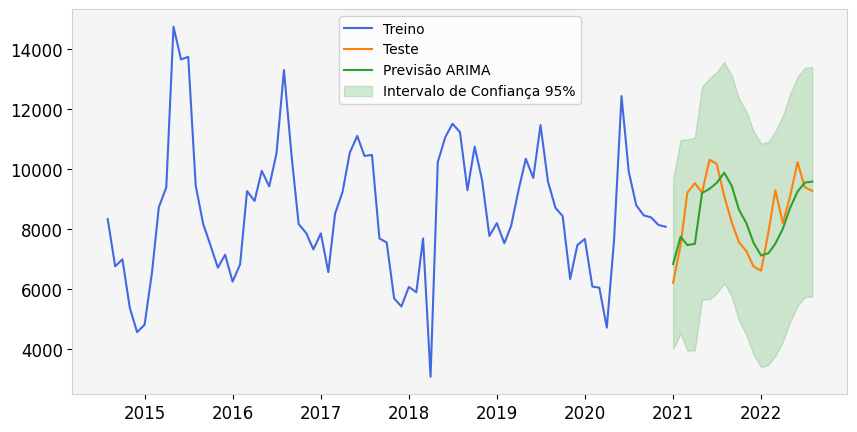

MAPE: 9.45%
RMSE: 973.51


In [376]:
fore_arima(6, 1, 6)

#### 4. Previsão com Aprendizagem de Máquina (Random Florest)

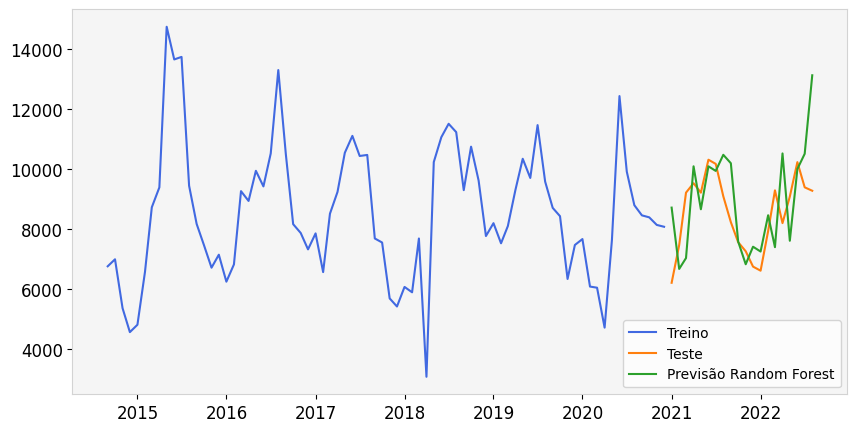

MAPE: 14.15%
RMSE: 1530.40


In [380]:
# 1. Carregar e ordenar dados
df_meses_v1 = df_meses_v1.sort_index()
data = df_meses_v1['qtdChamada']

# 2. Preparação dos dados para o modelo Random Forest
# Criar uma coluna para o lag de 1 período
df_lagged = pd.DataFrame(data)
df_lagged['lag_1'] = df_lagged['qtdChamada'].shift(1)

df_lagged_period = eixo_train

# Remover valores nulos criados pelo lagging
df_lagged.dropna(inplace=True)

# Separação em treino e teste
train_size = int(len(df_lagged) * 0.8)
train, test = df_lagged[:train_size], df_lagged[train_size:]

X_train, y_train = train[['lag_1']], train['qtdChamada']
X_test, y_test = test[['lag_1']], test['qtdChamada']

# 3. Treinamento do modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 4. Previsões no conjunto de teste
y_pred = rf_model.predict(X_test)

# 5. Visualização das Previsões
fig, ax = plt.subplots(figsize=(10, 5))
plot_ax(eixo_train[1:], y_train, ax, "", "", "Treino")
plot_ax(eixo_test, y_test, ax, "", "#ff7f0e", "Teste")
plot_ax(eixo_test, y_pred, ax, "", '#2ca02c', 'Previsão Random Forest')
ax.legend()
plt.show()

# 6. Avaliação das Métricas de Previsão
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAPE: {mape:.2%}")
print(f"RMSE: {rmse:.2f}")


5. Conclusão

...